In [6]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from numpy.linalg import svd
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns

import fig_gen as fg
import src.observing as OBS
import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL
import src.coordinates as CO

RS = SH.RealSphericalHarmonics()

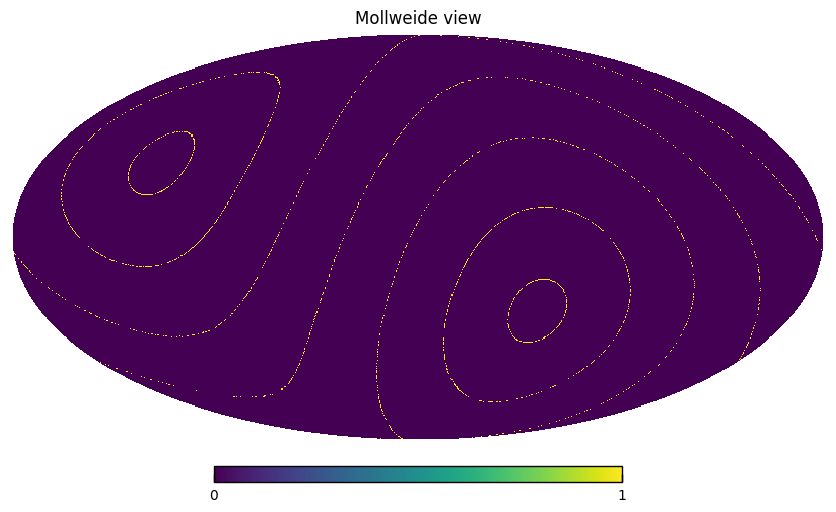

In [22]:
# Generate the sky tracks of 7 antennas.
lats = [-3*26, -2*26, -1*26, 0, 1*26, 2*26, 3*26]
coords = [CO.obs_zenith_drift_scan(lat, lon=0, times=np.linspace(0,24,1000)) for lat in lats]
nside=256
_,pix = CO.calc_pointing_matrix(*coords,nside=nside, pixels=True)
m = np.zeros(hp.nside2npix(nside))
m[pix] = 1
hp.mollview(m)
thetas, phis = hp.pix2ang(nside, pix)

In [36]:
# Generate the foreground sky alm at 60 MHz.
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=60, lmax=32, nside=32, use_mat_Y=True)

# Generate a beam matrix to observe it with.
mat_B  = BF.calc_beam_matrix(nside=32, lmax=32)

# Generate/load the spherical harmonic matrix.
mat_Y  = SH.calc_spherical_harmonic_matrix(nside=32, lmax=32)

# Split the spherical harmonic matrix into the low and high multipole sections, dividing at lmod.
lmod  = 3
Nlmod = RS.get_size(lmod)
mat_Y_mod   = mat_Y[:,:Nlmod]
mat_Y_unmod = mat_Y[:,Nlmod:]

# Convolve the foregrounds with the beam.
conv_fg = mat_B@fg_alm

# Transform with the spherical harmonic matrix.
mod_sky   = mat_Y_mod @ conv_fg[:Nlmod]
unmod_sky = mat_Y_unmod @ conv_fg[Nlmod:]
full_sky  = mat_Y @ conv_fg

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


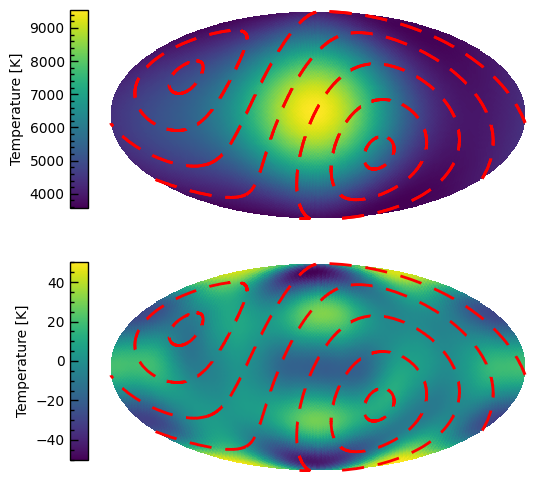

In [100]:
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
ls = (0, (8, 5))

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,6))
plt.axes(ax1)
hp.mollview(mod_sky, hold=True, cbar=None, title=None)
hp.projplot(thetas, phis, linestyle=ls, color='r', linewidth=2)

plt.axes(ax2)
hp.mollview(unmod_sky, hold=True, cbar=None, title=None)
hp.projplot(thetas, phis, linestyle=ls, color='r', linewidth=2)

normalize       = Normalize(vmin=np.min(mod_sky), vmax=np.max(mod_sky))
scalar_mappable = cm.ScalarMappable(norm=normalize)
colorbar_axis   = fig.add_axes([.16-0.06, .66-0.11, 0.03, .33])  # Colorbar location.
cbar1 = colorbar.ColorbarBase(colorbar_axis, norm=normalize, 
                    orientation='vertical', ticklocation='left')
cbar1.set_label(r'Temperature [K]')

normalize       = Normalize(vmin=np.min(unmod_sky), vmax=np.max(unmod_sky))
scalar_mappable = cm.ScalarMappable(norm=normalize)
colorbar_axis   = fig.add_axes([.16-0.06, 0.13, 0.03, .33])  # Colorbar location.
cbar2 = colorbar.ColorbarBase(colorbar_axis, norm=normalize, 
                    orientation='vertical', ticklocation='left')
cbar2.set_label(r'Temperature [K]')
plt.show()
